#### Red wine quality classification
this is my first notebook; of course there will be many mistakes and things to improve, but I hope that with your kind comments I can improve it :)

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).

first we import all the necessary libraries (I'm sure I import more than I need; this is my first point to improve :) )


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# for cross validation
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
# for metrics
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import classification_report
# plot
from matplotlib import rcParams
%config InlineBackend.figure_format = 'retina'
sns.set_style("white")
rcParams['figure.figsize'] = 6,4

In [2]:
# import data
dataset_url = r"C:\Users\gonza\OneDrive\Documentos\datascience-thebridge-master\ejercicios gonzalo\DATA\winequality-red.csv"
data = pd.read_csv(dataset_url,sep=";")
data.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


All of the features are numeric, which is convenient. However, they have some very different scales, so let's make a mental note to standardize the data later ¡¡

As we said before there are much more normal wines than excellent or poor ones

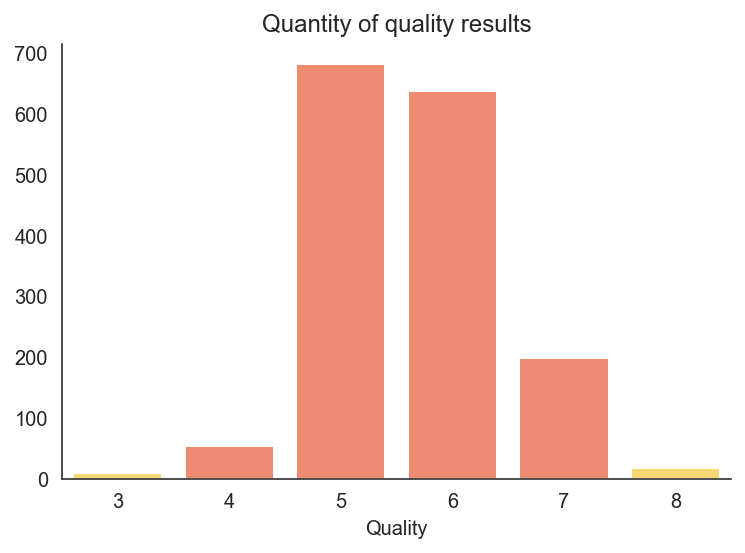

In [3]:
#I count the values and order them
quality_count = data.quality.value_counts().sort_index(ascending=False)

#I make a plot with seaborn, and i create a list of colours
colores = ["#F6D772","#EE8B73","#EE8B73","#EE8B73","#EE8B73","#F6D772"]
sns.barplot(x=quality_count.index,y=quality_count.values,palette=colores,saturation=1)
plt.title("Quantity of quality results")
plt.xlabel("Quality")
sns.despine()

I will create a function that first divides the wines into good and bad depending on their rating (up to 6.5 will be bad and above that good).

then I make a labelencoder to transform them into 0 and 1

In [4]:
def label_wine(Y):
    bins = (2, 6.5, 8)
    group_names = ['bad', 'good']    
    df = pd.cut(Y.astype("float"),bins=bins,labels=group_names)
    le = preprocessing.LabelEncoder()
    return le.fit_transform(df)

Now I want to contrast the characteristics of the wines according to whether they are good or bad.

First I make a copy of the dataframe, and then a new column using the old function (bad would be 0 and good would be 1)

In [5]:
# copy dataframe and create new column
data_copy = data.copy()
data_copy["quality_bin"] = label_wine(data_copy["quality"])

# now I filter the good ones and the bad ones, and I join them in a dataframe to make it visually more beautiful
bad_wine = data_copy.loc[data_copy["quality_bin"] == 0].mean()
good_wine = data_copy.loc[data_copy["quality_bin"] == 1].mean()
comparative_wine = pd.DataFrame(data={"bad_wine":bad_wine,"good_wine":good_wine})
comparative_wine.style.background_gradient(cmap="Reds",axis=1)

,bad_wine,good_wine
fixed acidity,8.236831,8.847005
volatile acidity,0.547022,0.405530
citric acid,0.254407,0.376498
residual sugar,2.512120,2.708756
chlorides,0.089281,0.075912
free sulfur dioxide,16.172214,13.981567
total sulfur dioxide,48.285818,34.889401
density,0.996859,0.996030
pH,3.314616,3.288802
sulphates,0.644754,0.743456


we see for example that the most relevant characteristics of good wines are fixed acidity, citric acid, residual sugar, sulphates and alcohol; and also a low proportion of sulphur, chlorides and volatile acidity	

we can do the same for example if we see the correlation of the characteristics with the quality

In [7]:
# first we use the correlation function; and then to visualize it I use style.background_gradient (in this case I use to_frame because as I have selected only one column and style it only works with dataframe)
#I know I'm not explaining myself very well, I hope you guys forgive me!

corr = data.corr()
corr.iloc[:,-1].sort_values(ascending=False).to_frame().style.background_gradient(cmap='PuRd')

,quality
quality,1.000000
alcohol,0.476166
sulphates,0.251397
citric acid,0.226373
fixed acidity,0.124052
residual sugar,0.013732
free sulfur dioxide,-0.050656
pH,-0.057731
chlorides,-0.128907
density,-0.174919


you can also see all the correlation of variables to see if there is multicollinearity (which there is not, there was a VIF of 2,0119)

In [8]:
corr.style.background_gradient(cmap='Blues')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


Well, let's go with the model (I could do more graphics but I prefer to go directly to the model and leave the analysis for another time)

In [9]:
#Split data into training and test sets.
X = data.drop("quality",axis=1)
Y = data.quality

X_train, X_test, y_train,y_test = train_test_split(X,Y, test_size=0.2,random_state=0,stratify=Y)

In [10]:
# now I use again the previous function to binarize Y at 0 and 1 (bad, good)
y_train_label = label_wine(y_train)
y_test_label = label_wine(y_test)

My approach will be as follows: first make a baseline with several models to see how they behave, then choose the one that works best, and then I will look for the best hyperparameters.
Let's hope it works and nobody dies in the attempt :)

I know there is a problem with the data, as it is not balanced. I will try to adjust certain parameters to see if I can improve them and change my Performance Metric (ideally find more data, Try Resampling Your Dataset, Try Generate Synthetic Samples ...)

In [11]:
# first I create a dictionary with several models, then (I hadn't forgotten!) I have to use standarscaler, and I use kfold to fight a bit with the Imbalanced Classes problem 

def baseline(X_train,y_train_label):
    models = {"rid":RidgeClassifier(),"log":LogisticRegression(random_state=0,                  
    class_weight="balanced"),"rdf":RandomForestClassifier(),"kne":KNeighborsClassifier(),"svc":SVC()}
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    kfold = KFold(n_splits=10, random_state=100)
    for key,model_kfold in models.items():        
        results_kfold = cross_val_score(model_kfold, X_train_scaled, y_train_label, cv=kfold)
        print(f"Accuracy {key}: {results_kfold.mean()*100.0}")

In [12]:
baseline(X_train,y_train_label)

Accuracy rid: 87.02202263779529
Accuracy log: 79.6751968503937
Accuracy rdf: 91.39763779527559
Accuracy kne: 87.33452263779527
Accuracy svc: 88.97453248031496


I should use performance measures that can give me more insight into the accuracy of the model than traditional classification accuracy:

* Confusion Matrix: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).
* Precision: A measure of a classifiers exactness.
* Recall: A measure of a classifiers completeness
* F1 Score (or F-score): A weighted average of precision and recall.

but for the moment I will only use accuracy to decide which model to use.

I find this article very good (in general everything he writes) and it has served me well

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [13]:
# we see that random forest had the best results, now we are going to look for the best hyperparameters ! 

n_estimators = [100, 300, 500]
max_depth = [5, 8, 15,30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10,50] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

def final_model_get_params(X_train,y_train_label):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, 
                        n_jobs = -1)
    bestF = gridF.fit(X_train_scaled,y_train_label)
    print(f"best params: {bestF.best_params_}")
    print(f"best results: {bestF.best_score_}")

In [14]:
final_model_get_params(X_train,y_train_label)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.8min finished
best params: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
best results: 0.9139958145961379


well we already have the best parameters, let's use them and see what happens (I corrected a couple of things: min_samples_leaf=2 and max_features=4, because I had read that with unbalanced classes it was not good to use 1 in sample leaf, and in max features to use between 30-50% of the features)

please any correction, help and improvement will be very useful and very welcome !

In [15]:
def final_model_predict_classification(X_train,X_test,y_train_label,y_test_label):
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    gridF = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=2,max_features=4, n_estimators=300,random_state=0,n_jobs=1,class_weight="balanced")
    gridF.fit(X_train_scaled,y_train_label)
    print(f"score with train data: {gridF.score(X_train_scaled,y_train_label)}")    
    print(f"score with test data: {gridF.score(X_train_scaled,y_train_label)}")    
    print(classification_report(y_test_label,gridF.predict(X_test_scaled)))

In [16]:
final_model_predict_classification(X_train,X_test,y_train_label,y_test_label)

score with train data: 0.9984362783424551
score with test data: 0.9984362783424551
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       277
           1       0.72      0.53      0.61        43

    accuracy                           0.91       320
   macro avg       0.82      0.75      0.78       320
weighted avg       0.90      0.91      0.90       320



it seems that there are problems of overfitting, the results are too good :(
that's why I want to use other metrics to see what's happening (classification report): we see as expected, as the classes are unbalanced, which predicts very well when the wine is bad but not so much when it's good (recall 0.53)

any idea that could save this project ?? :)

well, this is my first article on kaggle; of course it is very improvable, and for future challenges I promise to do my best.
 thank you very much for your patience and comments!
peace for all!